In [100]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [101]:
# directory for data
dataroot = "./data/"

# number of workers for dataloaders
workers = 2

# batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64

# number of channels in image
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

# number of training epochs
num_epochs = 5

# learning rate
learning_rate = 0.0022

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [102]:
# We cann use the entire dataset folder using ImageFolder
# creates dataset
dataset = dset.ImageFolder(root=dataroot, 
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# choose which device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

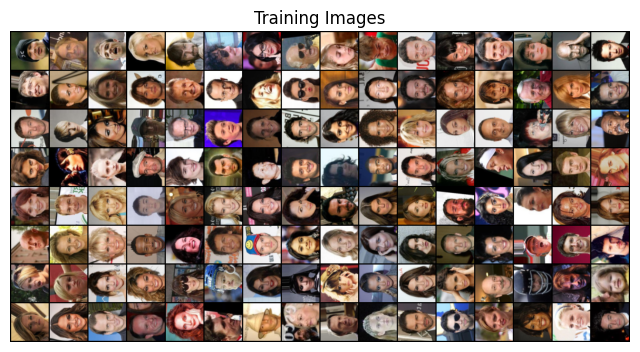

In [103]:
# plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True).cpu()))
plt.show()

In [104]:
# From DCGAN paper, model weights need to be randomly initialized from a normal distribution that has a mean=0 and stdev=0.02.
# custom weights initialization called on "netG" and "netD"
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Batchname') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# The function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet normal distrib criteria

In [105]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()       # initializes itself (VERY IMPORTANT)

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf * 8) x 4 x4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )

    def forward(self, input):
            return self.main(input)

In [106]:
# Now we can instantiate the generator and apply the weights_init function
# create the model
netG = Generator(ngpu).to(device)

# handle multi-gpu if desired
if ((device.type == 'cuda') and (ngpu > 1)):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the "weights_init" function to randomly initialize all weights to mean=0, stdev=0.02
netG.apply(weights_init)

# prints the generator model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [107]:
# discriminator (pretty much reverse of generator)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()            # initializes itself (VERY IMPORTANT)

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is a vector of shape: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape:ret (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # input shape: (ndf) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [108]:
# Now we can instantiate the discriminator and apply the weights_init function
netD = Discriminator(ngpu).to(device)

# handle multi-gpu if needed
if ((device.type == 'cuda') and (ngpu > 1)):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the "weights_init" function to randomly initialize all weights to mean=0, stdev=0.02
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


In [109]:
# Initialize teh BCELoss function
criterion = nn.BCELoss()

# Create the batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.rand(64, nz, 1, 1, device=device)

# Establish convention for fake and real labels
fake_label = 0
real_label = 1

# set up Adam optimizers for Discriminator and Generator
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [110]:
# Training a GAN model can be quite complex and tuning parameters incorrectly can cause model to collapse/fail with little info as to why
# Here are some best practices for trainign GANs https://github.com/soumith/ganhacks

# First we need to train the discriminator
# We need to first construct a batch of real samples, pass them through the discriminator, calculate the loss, then calculate the gradients in a backward pass
# Then we make a batch of fake samples, pass them through the discriminator, caclulate the loss, and then accumulate the gradients with a backward pass
# Now, with gradients from both fake and real samples, we call a step of the discriminator

# Secondly, we need to train the generator
# For better generator output we need to minimize log(1−D(G(z)))    (log of (1 - Discriminator(Generator(input))))
# It is reccomended to: 
# classify generator output with discriminator, computing G's loss using real labels as GT, computing G's gradients in a backward pass, and updating G's parameters with an optimizer step


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting training loop...")
# for each epoch
for epoch in range(num_epochs):
    # for each batch in dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all real batch
        netD.zero_grad()
        # format batch
        real_cpu = data[0].to(device)      # images are moved to the "device" (ie. a GPU)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)
        # forward pass real batch through D
        output = netD(real_cpu).view(-1)        # view(-1) reshapes output to be a 1D tensor
        # calculate loss on all real batch
        errD_real = criterion(output, label)        # loss between output and labels
        # calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all fake batch
        # generate batch of latent vectors 
        noise = torch.rand(b_size, nz, 1, 1, device=device)
        # generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # classify all fake data with D
        output = netD(fake.detach()).view(-1)
        # calculate D loss on the all fake batch
        errD_fake = criterion(output, label)
        # calculatc the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # computer error of D as sum over the fake and real batches
        errD = errD_real + errD_fake
        # update D
        optimizerD.step()       # updates parameters based on accumulated gradients

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)         # fake labels are real for generator bacuse of "ganhacks" reccomendation
        # Since we just updated D, perform another forward pass of all-fake batch data through D
        output = netD(fake).view(-1)        # 1D array
        # calculate G's loss based on ouptu
        errG = criterion(output, label)
        # calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs -1) and (i == len(dataloader) -1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting training loop...
[0/5][0/1583]	Loss_D: 1.7803	Loss_G: 67.2360	D(x): 0.4801	D(G(z)): 0.5625 / 0.0000
[0/5][50/1583]	Loss_D: 0.0000	Loss_G: 70.8011	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.0000	Loss_G: 70.5846	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][150/1583]	Loss_D: 0.0000	Loss_G: 70.4442	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][200/1583]	Loss_D: 0.0000	Loss_G: 70.4842	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
